# IMDB Rewview Sentiment Prediction

In [1]:
# Import librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import contractions
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from contractions import contractions_dict
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud#
import itertools
import random
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import math
# id = link.split("/")[-2]
 
# downloaded = drive.CreateFile({'id':id})
# downloaded.GetContentFile('xclara.csv') 
 
# dataset = pd.read_csv('xclara.csv')
# dataset.head()



[nltk_data] Error loading punkt: <urlopen error [Errno 54] Connection
[nltk_data]     reset by peer>
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hozhihoong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Checking the information of data

In [2]:
dataset = pd.read_csv('IMDB Dataset.csv')
data = dataset

In [3]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
data.shape

(50000, 2)

In [6]:
data['review'].nunique()

49582

# Preprocessing Data

In [7]:
# remove dulplicate data
data.drop_duplicates(subset='review', keep='first', inplace=True)

# covert 1 for "postive" and 0 for neagtive
data['target'] = data["sentiment"].apply(lambda i: 1 if i == "positive" else 0)

In [8]:
data['sentiment'].value_counts() 

positive    24884
negative    24698
Name: sentiment, dtype: int64

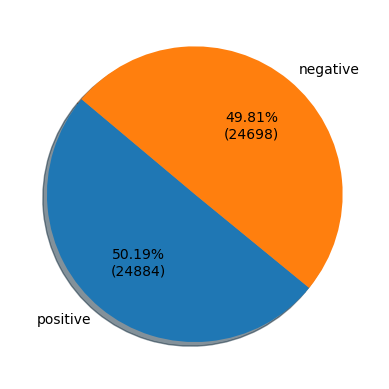

In [9]:
# Dataset visualization
def my_fmt(x):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)
sentiment_count = data["sentiment"].value_counts()
total = len(data)
plt.pie(sentiment_count, labels=sentiment_count.index,
        autopct=my_fmt, shadow=True, startangle=140)
plt.show()

# Text Normalization

In [10]:
# expand contractions

def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def replace(match):
        word = match.group(0).lower()
        return contractions_dict.get(word, word)

    expanded_text = contractions_pattern.sub(replace, text)
    return expanded_text

# this one better and faster
def fix_contractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet

In [11]:
# test for the expand contraction 

tweet = "LOOOOOOOOK at this ... I'd like it so much!!!!!"

# Test for first method
print("Firsst Method :" + expand_contractions(tweet,contractions_dict))

# test for second methos
print("Second Method : " +fix_contractions(tweet))

Firsst Method :LOOOOOOOOK at this ... i'd like it so much!!!!!
Second Method : LOOOOOOOOK at this ... I would like it so much!!!!!


In [11]:
def text_processing(review, default_replace=""):
    
    # convert review to lovwe case
    review = review.lower()
    
    # remove html tags
    review = re.sub('<.*?>', default_replace, review)
    
    # Remove urls
    review = re.sub('https?://\S+|www\.\S+', default_replace, review)
    
    #remove non character sysmbol include punctuation
    #review = re.sub('[^a-zA-Z]', default_replace, review)
    
    # remove white space
    #review = re.sub('^\s*|\s\s*', default_replace, review).strip()
    
    
    return review

In [13]:
#testing for text processing function
review1 = "An American actress Marigold, played by Ali Carter 33 gets stuck in India"
review2 = "<br /><br />anyway please tell me if you agree or disagree with me"
review3 = "One can also find good reviews regarding this movie at http://www.comingsoon.net/films.php?id=36310"
print(text_processing(review1))
print(text_processing(review2))
print(text_processing(review3))

an american actress marigold, played by ali carter 33 gets stuck in india
anyway please tell me if you agree or disagree with me
one can also find good reviews regarding this movie at 


In [12]:
# tokenization
def custom_tokenize(review):
  
    token_list = word_tokenize(review)

    #remove punctuatin
    token_list = [token for token in token_list
                   if token not in string.punctuation]

    
    #keep  alphabets only
    token_list = [token for token in token_list if token.isalpha()]
    
    #Remove stopwords

    stop_words = set(stopwords.words('english'))
    #stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]

    return token_list

In [16]:
#testing for tokenization fucntion
review4 = "an american actress marigold, played by ali carter 33 gets stuck in india"

def custom_tokenize_test(review):
  
    token_list = word_tokenize(review)
    print(token_list)
    #remove punctuation
    token_list = [token for token in token_list
                   if token not in string.punctuation]

    print(token_list)
    #keep  alphabets only
    token_list = [token for token in token_list if token.isalpha()]
    print(token_list)
    
    #Remove stopwords
    stop_words = set(stopwords.words('english'))
    #stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]
    print(token_list)
    return token_list

custom_tokenize_test(review4)

['an', 'american', 'actress', 'marigold', ',', 'played', 'by', 'ali', 'carter', '33', 'gets', 'stuck', 'in', 'india']
['an', 'american', 'actress', 'marigold', 'played', 'by', 'ali', 'carter', '33', 'gets', 'stuck', 'in', 'india']
['an', 'american', 'actress', 'marigold', 'played', 'by', 'ali', 'carter', 'gets', 'stuck', 'in', 'india']
['american', 'actress', 'marigold', 'played', 'ali', 'carter', 'gets', 'stuck', 'india']


['american',
 'actress',
 'marigold',
 'played',
 'ali',
 'carter',
 'gets',
 'stuck',
 'india']

In [13]:
def stem_tokens(tokens, stemmer):
    token_list = []
    for token in tokens:
        token_list.append(stemmer.stem(token))
    return token_list

In [18]:
#testing for stemming function 
stemmer = SnowballStemmer("english") # define stemmer
tok = ['american', 'actress', 'marigold', 'played', 'ali', 'carter', 'gets', 'stuck', 'india']

stem_tokens(tok,stemmer)

['american',
 'actress',
 'marigold',
 'play',
 'ali',
 'carter',
 'get',
 'stuck',
 'india']

In [14]:
def process_review(review):

    review = text_processing(review)
    review = fix_contractions(review)
    tokens = custom_tokenize(review)
    stemmer = SnowballStemmer("english") # define stemmer
    stem = stem_tokens(tokens, stemmer) # stem tokens

    return stem

In [20]:
# to print the tokenize word
for i in range(5):
    tweet_id = random.randint(0,len(data))
    tweet = data.iloc[tweet_id]["review"]
    print(process_review(tweet))
    print("\n")

['tenaci', 'pick', 'destini', 'tell', 'fiction', 'tale', 'format', 'band', 'tenaci', 'quest', 'find', 'pick', 'destini', 'guitar', 'pick', 'supernatur', 'power', 'made', 'tooth', 'satan', 'play', 'dave', 'grohl', 'jb', 'jack', 'black', 'kg', 'kyle', 'gass', 'join', 'togeth', 'fate', 'must', 'travel', 'rock', 'n', 'roll', 'museum', 'steal', 'pick', 'destini', 'becom', 'greatest', 'band', 'earth', 'movi', 'hilari', 'deliv', 'laugh', 'jack', 'black', 'kyle', 'gass', 'work', 'perfect', 'togeth', 'real', 'life', 'friend', 'year', 'film', 'part', 'music', 'music', 'written', 'perform', 'song', 'new', 'materi', 'mani', 'classic', 'soundtrack', 'definit', 'worth', 'check', 'film', 'most', 'appreci', 'fan', 'tenaci', 'fan', 'still', 'think', 'enjoy', 'movi', 'fan', 'must', 'see', 'movi', 'act', 'bad', 'may', 'think', 'laugh', 'crude', 'never', 'stop', 'come', 'high', 'recommend', 'movi', 'anyon', 'look', 'get', 'sock', 'rock', 'laugh', 'hard', 'laugh', 'long', 'time', 'look', 'cameo', 'dave', '

In [15]:
data["token"] = data["review"].apply(process_review)

In [16]:
data.head()

,review,sentiment,target,token
0,One of the other reviewers has mentioned that ...,positive,1,"[one, review, mention, watch, oz, episod, hook..."
1,A wonderful little production. <br /><br />The...,positive,1,"[wonder, littl, product, film, techniqu, fashi..."
2,I thought this was a wonderful way to spend ti...,positive,1,"[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,0,"[basic, famili, littl, boy, jake, think, zombi..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"[petter, mattei, love, time, money, visual, st..."


In [20]:
data['token'].

review       object
sentiment    object
target        int64
token        object
dtype: object

# EDA

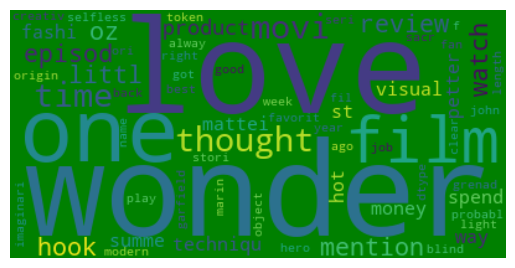

In [23]:
# token words appear in postive sentiment 
pos_tweets = data[data["sentiment"] == "positive"]
text = "".join(tweet.lower()for tweet in str(pos_tweets["token"]))
wordcloud = WordCloud(background_color='green').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

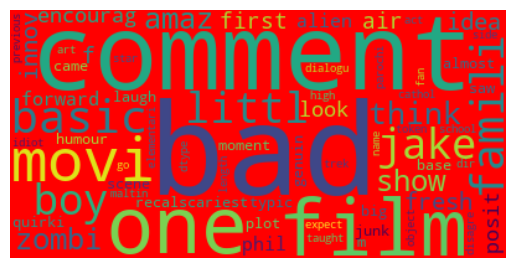

In [24]:
# token words appear in postive sentiment 
neg_tweets = data[data["sentiment"] == "negative"]
text = "".join(tweet.lower()for tweet in str(neg_tweets["token"]))
wordcloud = WordCloud(background_color='red').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
positive = data[data['sentiment']=='positive']
positive.reset_index(drop=True, inplace=True)
negative = data[data['sentiment']=='negative']
negative.reset_index(drop=True, inplace=True)

In [26]:
def count_frequency(tokens):
    word_count = {}
    for  token in tokens:
        for word in token:
        
            if word in word_count.keys():
                word_count[word] +=1
            else:
                word_count[word] = 1
    return word_count

In [27]:
postive_token_count = count_frequency(positive["token"])
negative_token_count =count_frequency(negative["token"])

In [28]:
# arrange in descenfding order
postive_token_count = {k: v for k, v in sorted(postive_token_count.items(), key=lambda item: item[1],reverse=True)}
negative_token_count = {k: v for k, v in sorted(negative_token_count.items(), key=lambda item: item[1],reverse=True)}

In [29]:
# to make the word count in dataframe
postive_word = pd.DataFrame(postive_token_count.keys(), columns=["Word"])
postive_word["Count"] = postive_token_count.values()

negative_word = pd.DataFrame(negative_token_count.keys(), columns=["Word"])
negative_word["Count"] = negative_token_count.values()

In [30]:
postive_word

,Word,Count
0,film,49185
1,movi,43271
2,one,27029
3,like,19900
4,time,15538
...,...,...
49459,eucharist,1
49460,censori,1
49461,burtolucci,1
49462,jossi,1


In [31]:
negative_word

,Word,Count
0,movi,55781
1,film,42884
2,one,25594
3,like,23755
4,would,17693
...,...,...
47469,nolin,1
47470,angelyn,1
47471,ktla,1
47472,girardot,1


In [32]:
def wordcount_plot(data_df,sentiment):
    
    
    data = data_df[0:20]
    print(data)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Count", y="Word", data=data,)
    plt.title(label="Top 20 wordcounts for {} sentiment".format(sentiment))
    plt.xlabel("Word")        
    plt.ylabel("Count")
    plt.show()

       Word  Count
0      film  49185
1      movi  43271
2       one  27029
3      like  19900
4      time  15538
5       see  14680
6      good  14624
7     stori  13688
8   charact  13641
9      make  13123
10    would  13106
11    great  13021
12      get  12527
13    watch  12500
14     love  12127
15     well  11395
16     show  10808
17   realli  10661
18     also  10558
19     play   9857


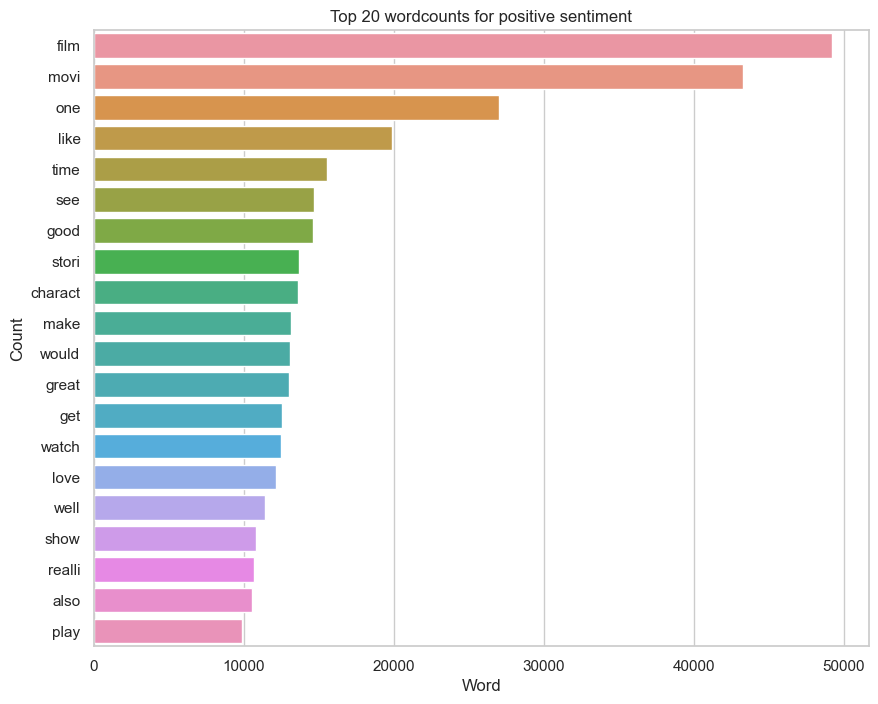

In [33]:
wordcount_plot(postive_word, "positive")

       Word  Count
0      movi  55781
1      film  42884
2       one  25594
3      like  23755
4     would  17693
5      make  15283
6       bad  15087
7      even  15074
8       get  14990
9     watch  14457
10     time  14303
11     good  14283
12  charact  13866
13      see  12771
14   realli  12148
15     look  11224
16    could  11211
17    scene  10974
18    stori  10538
19      act  10118


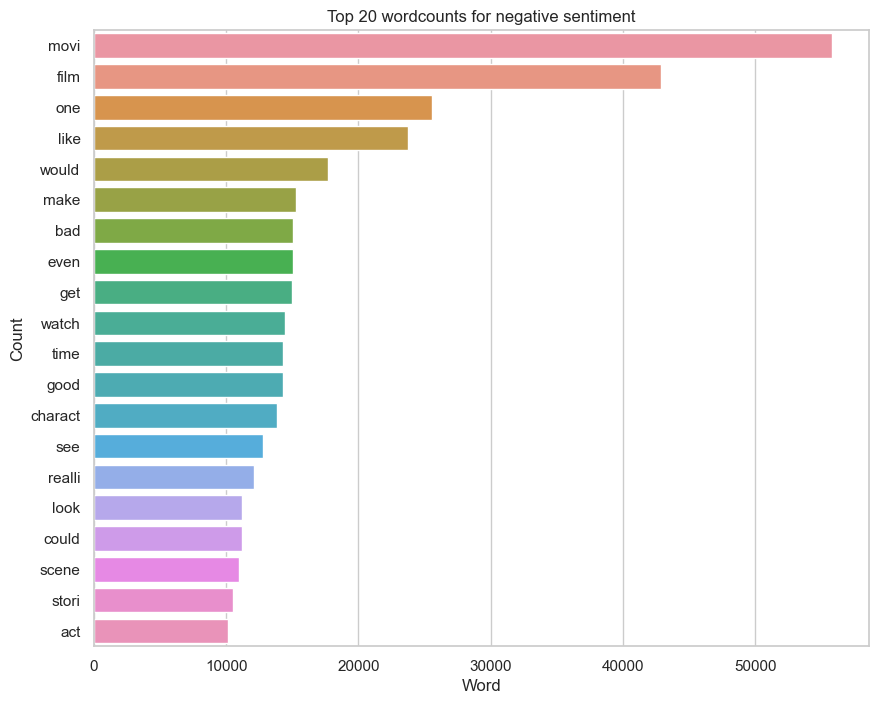

In [34]:
wordcount_plot(negative_word,"negative")

# Remove the Common Word 

In [35]:
# from the EDA part some words appear very frequent in both sentiment
# like 'movi','film','one','like' 
# try remove these word , to check is it help to improve performance

def remove_word (token):
    common_word = ["movi", "film","one","like"]
    token_new = token.copy()
    #print(token_new)
    for word in token_new:
        if word in common_word:
            token_new.remove(word)
    return token_new

In [36]:
data["token_new"] = data["token"].apply(remove_word)

In [37]:
data

,review,sentiment,target,token,token_new
0,One of the other reviewers has mentioned that ...,positive,1,"[one, review, mention, watch, oz, episod, hook...","[review, mention, watch, oz, episod, hook, rig..."
1,A wonderful little production. <br /><br />The...,positive,1,"[wonder, littl, product, film, techniqu, fashi...","[wonder, littl, product, techniqu, fashion, gi..."
2,I thought this was a wonderful way to spend ti...,positive,1,"[thought, wonder, way, spend, time, hot, summe...","[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,0,"[basic, famili, littl, boy, jake, think, zombi...","[basic, famili, littl, boy, jake, think, zombi..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visual, st..."
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,"[thought, movi, right, good, job, creativ, ori...","[thought, right, good, job, creativ, origin, f..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,"[bad, plot, bad, dialogu, bad, act, idiot, dir...","[bad, plot, bad, dialogu, bad, act, idiot, dir..."
49997,I am a Catholic taught in parochial elementary...,negative,0,"[cathol, taught, parochi, elementari, school, ...","[cathol, taught, parochi, elementari, school, ..."
49998,I'm going to have to disagree with the previou...,negative,0,"[go, disagre, previous, comment, side, maltin,...","[go, disagre, previous, comment, side, maltin,..."


# Train Test Split 

In [38]:
# for token
X = data["token"]
y = data["target"]
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.3)

# token_new
X_removed = data["token_new"]
X_train_re , X_test_re , y_train_re , y_test_re = train_test_split(X_removed , y , test_size=0.3)

# TF-IDF

In [39]:
tfid = TfidfVectorizer(use_idf=True)
def fit_tfidf(tweet_corpus):
    tf_vect = TfidfVectorizer(preprocessor = lambda x :x,
                            tokenizer = lambda x : x)
    tf_vect.fit(tweet_corpus)
    return tf_vect

In [40]:
# for token
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

# # for token_new
tf_re = fit_tfidf(X_train_re)
X_train_tf_re =  tf_re.transform(X_train_re)
X_test_tf_re = tf_re.transform(X_test_re)

/Users/hozhihoong/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [41]:
X_train_tf.shape

(34707, 58403)

In [42]:
y_train.shape

(34707,)

# Logistic Regression

## For original token

In [129]:
model = LogisticRegression()
model.fit(X_train_tf, y_train)

LogisticRegression()

In [130]:
y_pred_tf = model.predict(X_test_tf)

print("Logistics Regression Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_tf)))
print("Logisitic Regression Model Recall Score : {:.2%}".format(recall_score(y_test, y_pred_tf)))
print("Logistoc Regression Model Precision Score : {:.2%}".format(precision_score(y_test, y_pred_tf)))
print(classification_report(y_test,y_pred_tf))

Logistics Regression Model Accuracy: 88.38%
Logisitic Regression Model Recall Score : 90.14%
Logistoc Regression Model Precision Score : 87.21%
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      7383
           1       0.87      0.90      0.89      7492

    accuracy                           0.88     14875
   macro avg       0.88      0.88      0.88     14875
weighted avg       0.88      0.88      0.88     14875



In [131]:
lr_accu =accuracy_score(y_test, y_pred_tf)*100
lr_recall = recall_score(y_test, y_pred_tf)*100
lr_precision = precision_score(y_test, y_pred_tf)*100

In [132]:
def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sns


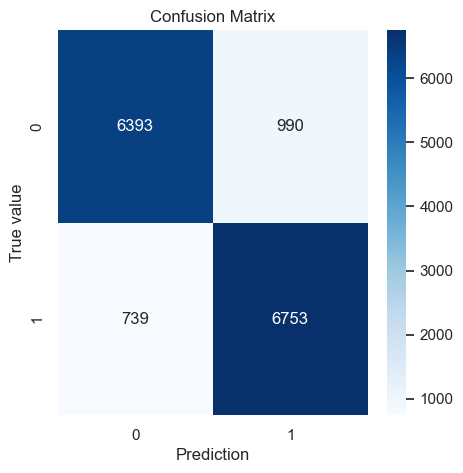

In [133]:
plot_confusion(confusion_matrix(y_test, y_pred_tf));

In [134]:
mask = (y_test != y_pred_tf)
false_classification = X_test[mask]

In [135]:
# show wrong classification example

#mask = (y_test != y_pred_tf)
#false_classification = X_test[mask]

for i in range (5):
    index = random.randint(0, len(false_classification))
    
    false_example = false_classification.iloc[index]
    
    mask_2 = data["token"].apply(lambda i : i ==false_example)
    
    print('Review : ' + str(list(data[mask_2]["review"])))
    
    print("\nSentiment : " + str(list(data[mask_2]["sentiment"])))

    predict_sentiment = lambda i : "postive" if i==1 else "negative"
    
    print("\nPredicted Sentiment :" + predict_sentiment(y_pred_tf[list(X_test).index(false_example)]))
    print("\n\n")

Review : ['I\'ll admit that this isn\'t a great film. It practically screams "low-budget" yet oddly I still found myself liking the film because although it lacked quality it abounded with energy. It was like the Little Engine That Could and a movie merged into one! <br /><br />The film takes place at a radio network and concerns some of their low-level employees--two page boys (one very pushy and brash and the other one a wuss) as well as a new receptionist. All three have visions of radio stardom but must for now content themselves with their lowly jobs.<br /><br />Into this story appears a murder that seems somewhat out of the blue. I didn\'t know that this was a murder mystery film and was taken a bit by surprise. However, like most B-mysteries, the cops are lamebrains and it\'s up to our pushy hero (Moran) to try to save the day. Throughout all this, I had a hard time deciding if Moran was obnoxious or endearing. I\'m still not sure!! <br /><br />There is a moment in the film that

## For new token (common words are removed)

In [136]:
model.fit(X_train_tf_re, y_train_re,)


LogisticRegression()

In [137]:
y_pred_tf_re = model.predict(X_test_tf_re)
print("Logistics Regression Model Accuracy: {:.2%}".format(accuracy_score(y_test_re, y_pred_tf_re)))
print("Logisitic Regression Model Recall Score : {:.2%}".format(recall_score(y_test_re, y_pred_tf_re)))
print("Logistoc Regression Model Precision Score : {:.2%}".format(precision_score(y_test_re, y_pred_tf_re)))
print(classification_report(y_test_re,y_pred_tf_re))

Logistics Regression Model Accuracy: 88.95%
Logisitic Regression Model Recall Score : 90.34%
Logistoc Regression Model Precision Score : 87.86%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7454
           1       0.88      0.90      0.89      7421

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



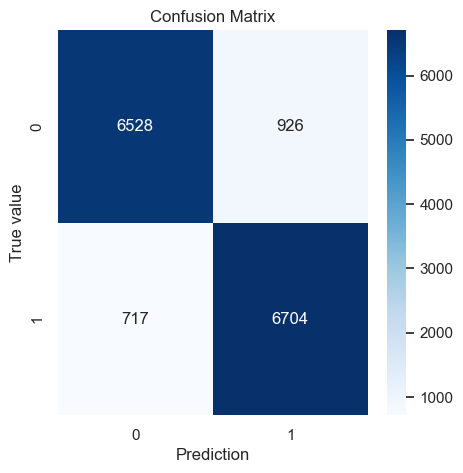

In [138]:
plot_confusion(confusion_matrix(y_test_re,y_pred_tf_re));

In [139]:
lr_accu_re = accuracy_score(y_test_re, y_pred_tf_re)*100
lr_recall_re = recall_score(y_test_re, y_pred_tf_re)*100
lr_precison_re =precision_score(y_test_re, y_pred_tf_re)*100

## RANDOM FOREST OLD TOKENS 

In [140]:
# Random Forest Model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_tf, y_train)


RandomForestClassifier()

In [141]:
y_pred_tf_random_forest = random_forest_model.predict(X_test_tf)

In [142]:
rf_accu = accuracy_score(y_test, y_pred_tf_random_forest)*100
rf_recall = recall_score(y_test, y_pred_tf_random_forest)*100
rf_precision = precision_score(y_test, y_pred_tf_random_forest)*100
print("Random Forest Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_tf_random_forest)))
print("Random Forest Model Recall Score: {:.2%}".format(recall_score(y_test, y_pred_tf_random_forest)))
print("Random Forest Model Precision Score: {:.2%}".format(precision_score(y_test, y_pred_tf_random_forest)))
print(classification_report(y_test, y_pred_tf_random_forest))

Random Forest Model Accuracy: 84.11%
Random Forest Model Recall Score: 84.38%
Random Forest Model Precision Score: 84.13%
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      7383
           1       0.84      0.84      0.84      7492

    accuracy                           0.84     14875
   macro avg       0.84      0.84      0.84     14875
weighted avg       0.84      0.84      0.84     14875



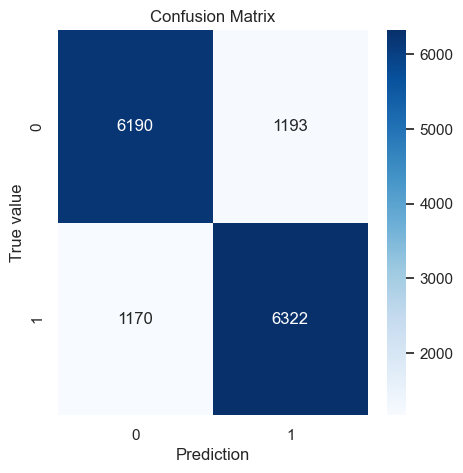

In [143]:
plot_confusion(confusion_matrix(y_test, y_pred_tf_random_forest));

In [144]:
mask_random_forest = (y_test != y_pred_tf_random_forest)
false_classification_random_forest = X_test[mask_random_forest]

In [145]:
for i in range(5):
    index = random.randint(0, len(false_classification_random_forest))
    false_example = false_classification_random_forest.iloc[index]
    
    mask_2 = data["token"].apply(lambda i: i == false_example)
    
    print('Review (Random Forest): ' + str(list(data[mask_2]["review"])))
    print("\nSentiment: " + str(list(data[mask_2]["sentiment"])))
    
    predict_sentiment = lambda i: "positive" if i == 1 else "negative"
    
    print("\nPredicted Sentiment (Random Forest): " + predict_sentiment(y_pred_tf_random_forest[list(X_test).index(false_example)]))
    print("\n\n")

Review (Random Forest): ["When I rented this movie, I half expected it to be a low budget, plot less Indy film, but thought I'd give it a try. I started watching Part 1 and couldn't pull myself away till it ended 3 hours later. It was by far one of my absolute favorite films of all time. From the writing to the directing to the performances, I was laughing, crying, and singing all the way through Nan Astley's rite of passage from innocence to adulthood. Rachael Stirling is phenomenal in this film. I had never heard of her before, but now I will forever remember the vulnerability and strength I felt in her performance. She, Keeley Hawes, and Jodhi May are incredible as they guide you through the emotional turmoils that most feel as they deal with an alternate form of sexuality. The fact that the film is set in the 1890's not only educates the audience about homosexuality in that time period, but makes a statement about our society today. You must see this film and, probably like myself,

# NEW TOKEN (RF)

In [146]:
random_forest_model.fit(X_train_tf_re, y_train_re)

y_pred_tf_re = random_forest_model.predict(X_test_tf_re)

print("Random Forest Model Accuracy: {:.2%}".format(accuracy_score(y_test_re, y_pred_tf_re)))
print("Random Forest Model Recall Score: {:.2%}".format(recall_score(y_test_re, y_pred_tf_re)))
print("Random Forest Model Precision Score: {:.2%}".format(precision_score(y_test_re, y_pred_tf_re)))
print(classification_report(y_test_re, y_pred_tf_re))

Random Forest Model Accuracy: 85.11%
Random Forest Model Recall Score: 85.61%
Random Forest Model Precision Score: 84.71%
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      7454
           1       0.85      0.86      0.85      7421

    accuracy                           0.85     14875
   macro avg       0.85      0.85      0.85     14875
weighted avg       0.85      0.85      0.85     14875



In [147]:
rf_accu_re = accuracy_score(y_test_re, y_pred_tf_re)*100
rf_recall_re =recall_score(y_test_re, y_pred_tf_re)*100
rf_precision_re = precision_score(y_test_re, y_pred_tf_re)*100

# Support Vector Machine (SVM) - old token 

In [148]:
# Create an instance of the SVM classifier
svm_model =  LinearSVC(loss='hinge')
# Train the SVM model
svm_model.fit(X_train_tf, y_train)

LinearSVC(loss='hinge')

SVM Model Precision Score: 87.69%
SVM Forest Model Recall Score: 90.10%
SVM Forest Model Accuracy: 88.64%
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      7383
           1       0.88      0.90      0.89      7492

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



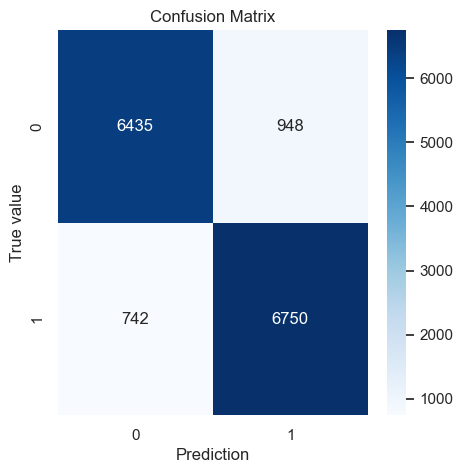

In [149]:
# Make predictions
y_pred_tf_svm = svm_model.predict(X_test_tf)

print("SVM Model Precision Score: {:.2%}".format(precision_score(y_test, y_pred_tf_svm)))
print("SVM Forest Model Recall Score: {:.2%}".format(recall_score(y_test, y_pred_tf_svm)))
print("SVM Forest Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_tf_svm)))

print(classification_report(y_test, y_pred_tf_svm))

plot_confusion(confusion_matrix(y_test, y_pred_tf_svm));


In [150]:
svm_accu = accuracy_score(y_test, y_pred_tf_svm)*100
svm_recall = accuracy_score(y_test, y_pred_tf_svm)*100
svm_precision = precision_score(y_test, y_pred_tf_svm)*100

In [151]:
mask_svm = (y_test != y_pred_tf_svm)
false_classification_svm = X_test[mask_svm]

In [152]:
for i in range(5):
    index = random.randint(0, len(false_classification_svm))
    false_example = false_classification_svm.iloc[index]

    mask_2 = data["token"].apply(lambda i: i == false_example)

    print('Review (SVM): ' + str(list(data[mask_2]["review"])))
    print("\nSentiment: " + str(list(data[mask_2]["sentiment"])))

    predict_sentiment = lambda i: "positive" if i == 1 else "negative"

    print("\nPredicted Sentiment (SVM): " + predict_sentiment(y_pred_tf_svm[list(X_test).index(false_example)]))
    print("\n\n")


Review (SVM): ["This movie was the beatliest mormon movie made yet. It made the RM & Sons of Provo look like well done films! It was supposed to be funny from what I was told. The best part was the best actor in the movie-Travis Eberhard-if he wasn't in the movie it probably wouldn't have been made! He ruled!<br /><br />10. It wasn't funny 9. It was beat 8. It had Thurl Big T Bailey, who's character made no sense 7. It was made in Provo 6. It didn't make fun of Brokeback 5. It had Larry H. Miller in it 4. It was the 1st movie Clint Howard wasn't funny in 3. Gary Coleman chose the perfect movie 4 a comeback 2. They should have cast at Surreal Life auditions 1. It was made by Halestorm Entertainment!!"]

Sentiment: ['negative']

Predicted Sentiment (SVM): positive



Review (SVM): ["Paul Naschy as a ghostly security guard in this is scarier than most of his fur-and-shoe-polish werewolf guises. The story is not unfamiliar, a bunch of kids going to party at an abandoned school. The thing i

# New Token (SVM)- ( common words are removed)

SVM Forest Model Accuracy: 88.80%
SVM Model Precision Score: 88.19%
SVM Forest Model Recall Score: 89.54%
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7454
           1       0.88      0.90      0.89      7421

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



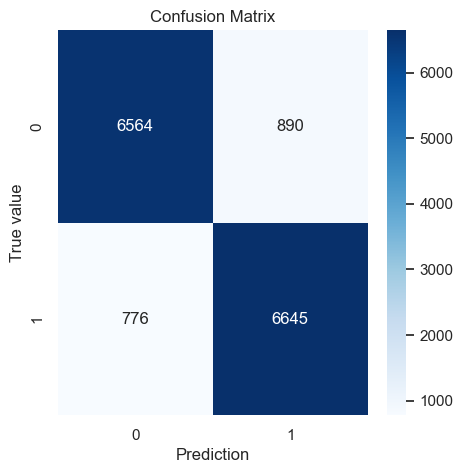

In [153]:
svm_model.fit(X_train_tf_re, y_train_re)

y_pred_tf_re_svm = svm_model.predict(X_test_tf_re)



print("SVM Forest Model Accuracy: {:.2%}".format(accuracy_score(y_test_re, y_pred_tf_re_svm)))
print("SVM Model Precision Score: {:.2%}".format(precision_score(y_test_re, y_pred_tf_re_svm)))
print("SVM Forest Model Recall Score: {:.2%}".format(recall_score(y_test_re, y_pred_tf_re_svm)))

print(classification_report(y_test_re, y_pred_tf_re_svm))


plot_confusion(confusion_matrix(y_test_re, y_pred_tf_re_svm));


In [154]:
svm_accu_re = accuracy_score(y_test_re, y_pred_tf_re_svm)*100
svm_recall_re =recall_score(y_test_re, y_pred_tf_re_svm)*100
svm_precision_re = precision_score(y_test_re, y_pred_tf_re_svm)*100

# Compare the Performance

In [155]:
accuracy = [lr_accu, rf_accu,svm_accu]
recall = [lr_recall,rf_recall,svm_recall]
precision =[lr_precision ,rf_precision, svm_precision]

accuracy_re = [lr_accu_re, rf_accu_re,svm_accu_re]
recall_re = [lr_recall_re,rf_recall_re,svm_recall_re]
precision_re = [lr_precison_re ,rf_precision_re, svm_precision_re]

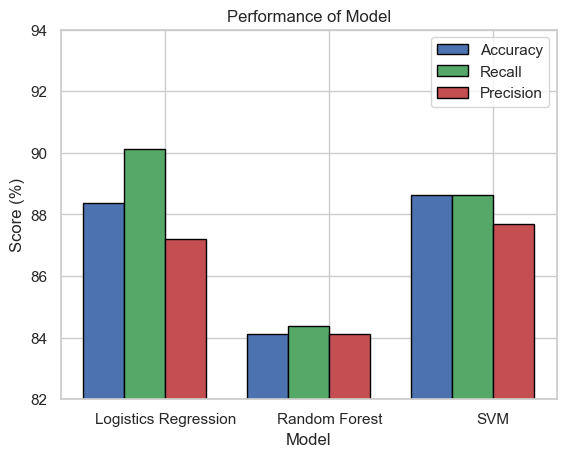

In [156]:
# Compare the performance for the coomen words are not removed
n=3
r = np.arange(n)
width = 0.25

low = min((min(accuracy),min(recall),min(precision)))
high = max((max(accuracy),max(recall),max(precision)))
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.bar(r,accuracy , color = 'b',
        width = width, edgecolor = 'black',
        label='Accuracy')

plt.bar(r+width,recall , color = 'g',
        width = width, edgecolor = 'black',
        label='Recall')

plt.bar(r+width*2,precision , color = 'r',
        width = width, edgecolor = 'black',
        label='Precision')

plt.legend()
plt.xlabel("Model")
plt.ylabel("Score (%)")
plt.title("Performance of Model")
  

plt.xticks(r + width* 3/2,['Logistics Regression','Random Forest','SVM']);

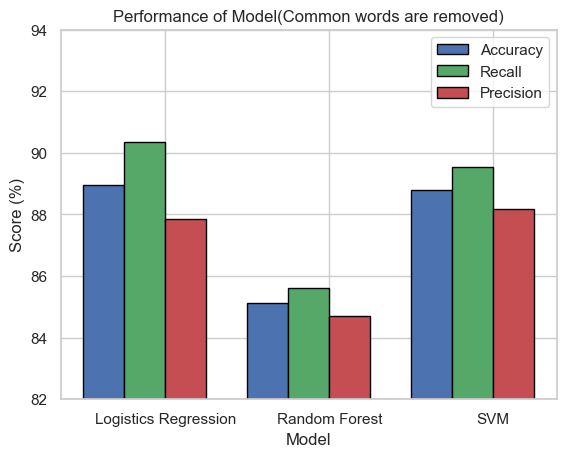

In [157]:
low = min((min(accuracy_re),min(recall_re),min(precision_re)))
high = max((max(accuracy_re),max(recall_re),max(precision_re)))
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.bar(r,accuracy_re , color = 'b',
        width = width, edgecolor = 'black',
        label='Accuracy')

plt.bar(r+width,recall_re , color = 'g',
        width = width, edgecolor = 'black',
        label='Recall')

plt.bar(r+width*2,precision_re , color = 'r',
        width = width, edgecolor = 'black',
        label='Precision')
plt.legend()
plt.xlabel("Model")
plt.ylabel("Score (%)")
plt.title("Performance of Model(Common words are removed)")
  

plt.xticks(r + width* 3/2,['Logistics Regression','Random Forest','SVM']);